<table width="100%">
    <td align="left">
        <a target="_blank", href="https://www.up.pt/fcup/en/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2023/03/FCUP_logo-print_blcktransp_600ppi.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td>
        <a target="_blank", href="https://www.iastro.pt/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2018/03/IA_logo_bitmap-rgbblack-1200px-388x259.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td align="center">
        <a target="_blank" href="https://colab.research.google.com/github/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-07-combining%20estimators.ipynb">
           <img src="https://tinyurl.com/3mm2cyk6"  width="90px" height="90px" style="padding-bottom:5px;"/>Run in Google Colab
        </a>
    </td>
<td align="center"><a target="_blank" href="https://github.com/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-07-combining%20estimators.ipynb">
<img src="https://tinyurl.com/25h5fw53"  width="90px" height="60px" style="padding-bottom:0px;"  />View Source on GitHub</a></td>
</table>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table

# Ensemble methods

Ensemble methods are many and varied. They all make use of the fact that combining several simple learners can lead to a final estimator with both low bias and lower variance. This notebook shows some practical examples of this.

## Bagging

This method uses bootstrap repetition of the sample to create a stable fit. This can be used for instance to create stable higher order polynomial fits or k-neighbours regression.

To illustrate the use, let us first see how you can simply implement this yourself and then move to the `sklearn` implementation.

The first step then is to create a simple random dataset:

In [5]:
def func(x):
    return np.sin(2*x)

def draw_random_data(N=15):
    """Draw a few points from a sin(2*x).
    
    Return: x, y, dy. dy is a noise array that can be added to y to incorporate
            some noise in the data.        
    """
    np.random.seed(100)
    x = np.random.uniform(-3, 3, N)
    dy = np.random.normal(0, 0.4, size=N)
    y = func(x)
    return x, y, dy

x, y, dy = draw_random_data()
xtrue = np.linspace(-3, 3, 500)
ytrue = func(xtrue)

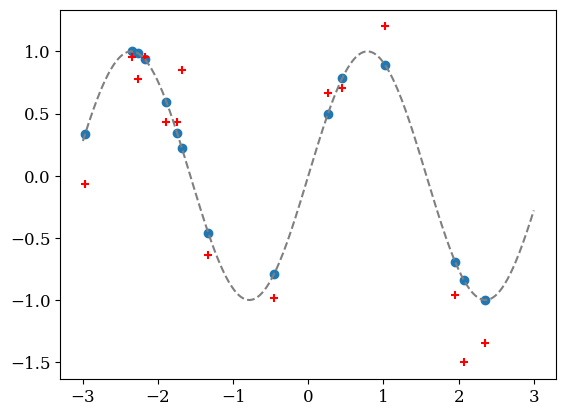

In [6]:
plt.scatter(x, y)
plt.scatter(x, y+dy, marker='+', color='red')
plt.plot(xtrue, ytrue, ls='dashed', color='grey')

## Build a bagging estimator from scratch

We start here by creating a function for the regressor we will use. In this case I will use a k-nearest neighbour regressor, but you could substitute this function for something else. It is however generally most interesting to use a regressor that has some local structure. You will see below that I both to get the evaluation at the input points and at a x variable for plotting - this is of course for visual inspection of the results. 

In [7]:
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.utils import resample

def my_regression(x, y, k=3, weights='uniform', xplot=None):
    """The regression function to use for bagging.
    """
    
    # Initialise the regressor object
    knn = KNeighborsRegressor(n_neighbors=k, weights=weights)
    
    # Run the fit
    knn.fit(x[:, np.newaxis], y)
    
    # Predict results
    ypred = knn.predict(x[:, np.newaxis])
    if xplot is not None:
        yplot = knn.predict(xplot[:, np.newaxis])
    else:
        yplot = ypred
    
    return ypred, yplot, knn    

The next step is to run this fit. If we just fit our data once, then we just get the KNN regressor. In bagging we loop over many times, picking a random subsample with replacement each time. We will use the `sklearn.utils.resample` function to create a resampled array. To check how that works we can do the draw explicitly - note that of course `x2` and `y2` have the same number of elements as `x` and `y`, it is just that some are repeated.

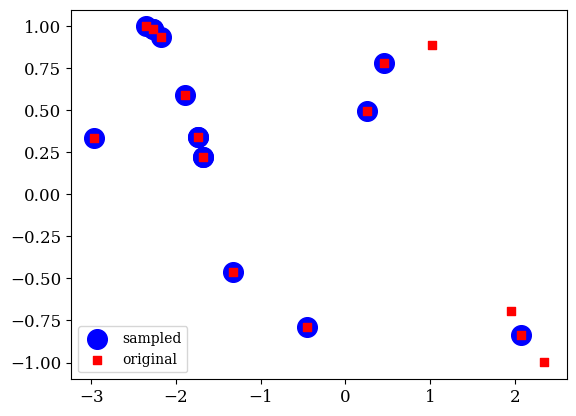

In [8]:

x2, y2 = resample(x, y, replace=True)
plt.scatter(x2, y2, 200, color='blue', label='sampled')
plt.scatter(x, y, color='red', marker='s', label='original')
plt.legend(loc=3)

In [9]:
def my_bagging_regressor(x, y, k=3, weights='uniform', n_estimators=10):
    """
    Carry out bagging regression using kNN regression
    """
    
    xplot = np.linspace(-3, 3, 200)
    
    # We carry out n_estimators fits
    estimators = []
    ypred = np.zeros((len(x), n_estimators))
    yplot = np.zeros((len(xplot), n_estimators))
    for i_est in range(n_estimators):
        # Draw a resampled version with replacement
        xr, yr = resample(x, y, replace=True)
        
        # Run the fit - note that I input the _RESAMPLED_ values
        t_ypred, t_yplot, t_knn = my_regression(xr, yr, k=k, weights=weights, xplot=xplot)
        ypred[:, i_est] = t_ypred
        yplot[:, i_est] = t_yplot
        estimators.append(t_knn)
    
    return ypred, estimators, xplot, yplot

We are now ready to run this estimator. The `weight` option is also worth commenting on - the default is to simply take the average of the `k`-nearest neighbours. This is what you get if you set `weights='uniform'`, but it is also possible to add a weight to the estimates that is inversely proportional to the distance, so that more distant points are down-weighted. This can be achieved by setting `weights='distance'` - try both to get a feel for it.

In [10]:
n_est = 10
ypred, est, xp, yp = my_bagging_regressor(x, y, k=3, weights='distance', n_estimators=n_est)

This gives us the result for each individual run (because I wanted those for plotting). We do however usually only care about the averaged fits. So let us calculate the mean predicted y values both for the individual points and for the plot values.

In [11]:
ym = np.mean(ypred, axis=1)
ypm = np.mean(yp, axis=1)

Finally, we can plot this. The plot below shows 5 random fits as dotted gray lines and then the average line in red and the truth as a dashed black line.

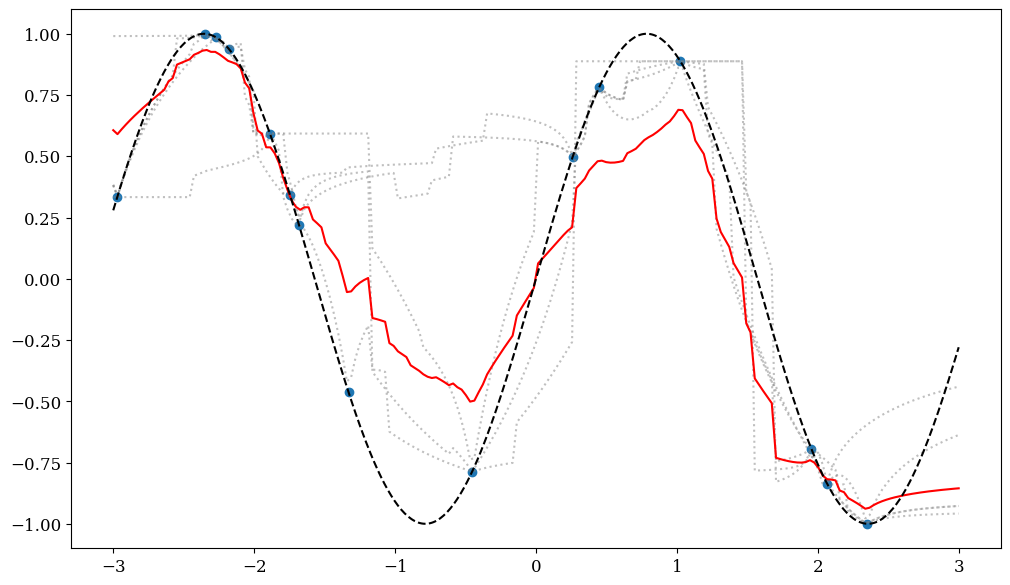

In [12]:
plt.scatter(x, y)
inds = np.arange(n_est)
np.random.shuffle(inds)
for i_t in range(5):
    i = inds[i_t]
    plt.plot(xp, yp[:, i], color='gray', alpha=0.5, ls='dotted')
plt.plot(xp, ypm, color='red')
plt.plot(xtrue, ytrue, ls='dashed', color='black')
fig = plt.gcf()
fig.set_size_inches(12, 7)

## Bagging using sklearn

As you can see above, writing your own bagging function is not that hard, and will help you understand what is going on, but for your convenience, `sklearn` has a bagging package as well which we can now try.

To use `sklearn.ensemble.BaggingRegressor` we need to define a regressor to use. I'll use k-nearest neighbours again:

In [13]:
from sklearn.ensemble import BaggingRegressor

knn = KNeighborsRegressor(n_neighbors=3, weights='distance')
bgr = BaggingRegressor(knn, n_estimators=n_est)

In [14]:
r = bgr.fit(x[:, np.newaxis], y)

In [15]:
yplot_sk = r.predict(xp[:, np.newaxis])

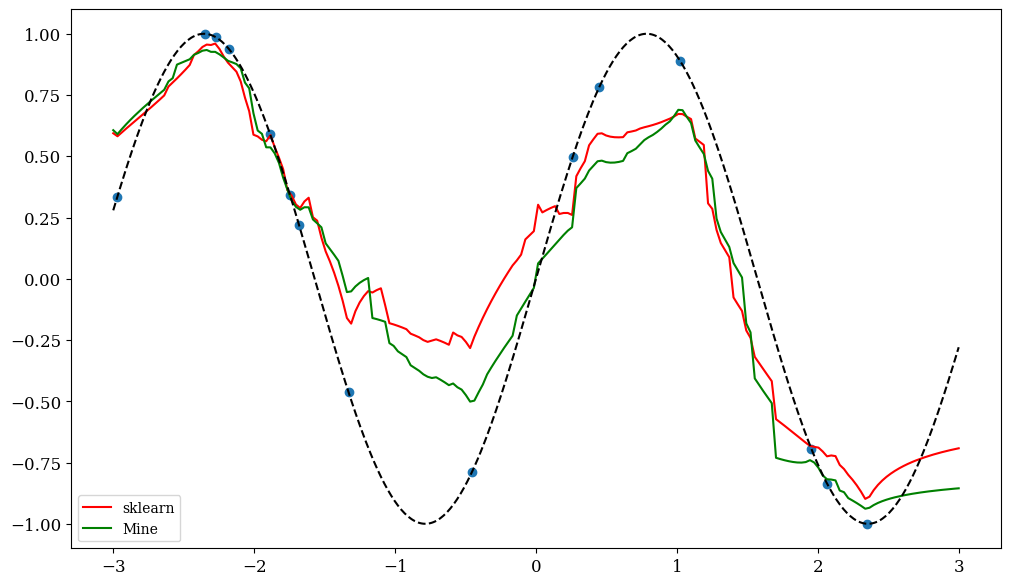

In [16]:
plt.scatter(x, y)
plt.plot(xp, yplot_sk, color='red', label='sklearn')
plt.plot(xp, ypm, color='green', label='Mine')
plt.plot(xtrue, ytrue, ls='dashed', color='black')
plt.legend(loc=3)
fig = plt.gcf()
fig.set_size_inches(12, 7)

The two do disagree a bit but the code should be pretty much identical so it should be mostly just random scatter.

# Boosting

The next ensemble method we discussed was boosting. This is also not very challenging to implement yourself but it is probably just as well to start directly with `sklearn` here. 

The best known of these techniques is the AdaBoost method. Here I will first use this on the same regression problem above, and then use it as a classifier on a real problem (classifying stars).

In [17]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score

I will first run in default mode where the regressor is a Decision tree regressor. 

In [18]:
reg = AdaBoostRegressor(n_estimators=100)

In [19]:
r_reg = reg.fit(x[:, np.newaxis], y)
yplot_boost = reg.predict(xp[:, np.newaxis])

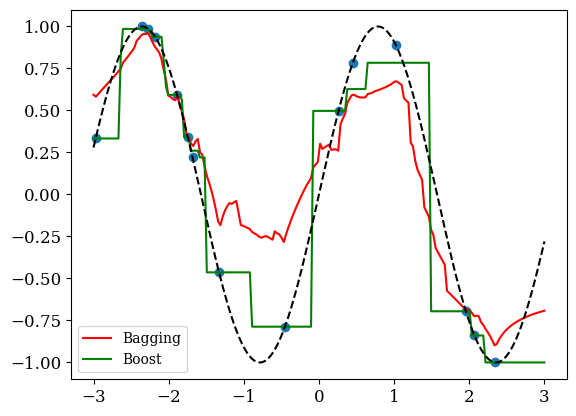

In [20]:
plt.scatter(x, y)
plt.plot(xp, yplot_sk, color='red', label='Bagging')
plt.plot(xp, yplot_boost, color='green', label='Boost')
plt.plot(xtrue, ytrue, ls='dashed', color='black')
plt.legend(loc=3)

We can also run this with a k-nearest neighbours regressor.

In [21]:
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_boost = AdaBoostRegressor(knn, n_estimators=100)

In [22]:
r_boost_knn = knn_boost.fit(x[:, np.newaxis], y)
yplot_boost_knn = knn_boost.predict(xp[:, np.newaxis])

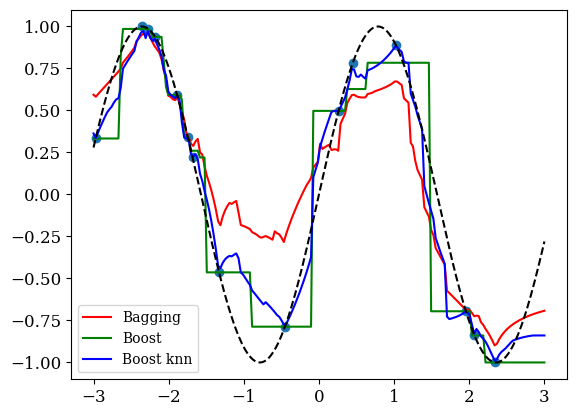

In [23]:
plt.scatter(x, y)
plt.plot(xp, yplot_sk, color='red', label='Bagging')
plt.plot(xp, yplot_boost, color='green', label='Boost')
plt.plot(xp, yplot_boost_knn, color='blue', label='Boost knn')
plt.plot(xtrue, ytrue, ls='dashed', color='black')
plt.legend(loc=3)

In [24]:
scores = cross_val_score(knn_boost, x[:, np.newaxis], y, scoring="neg_mean_squared_error") 

In [25]:
scores

array([-0.94574871, -0.07148749, -0.07307983, -0.06054227, -0.01025073])

## Trying a more realistic example

These kinds of methods are not particularly interesting for 1D fitting problems - these examples are used because it is easy to visualise the results. Let us now turn to a more realistic question. We will return to the colours of stars and trying to estimate the temperature of the stars from their colours.

In [26]:
from astroML.datasets import fetch_sdss_sspp

In [27]:
# If you have good internet connection you can do this:
#d = fetch_sdss_sspp()
#t = Table(d)

# If you have the data downloaded, do this:
t = Table().read("star_properties.fits")

In [28]:
# Extract some data. 
ug = data['upsf']-data['gpsf']
gr = data['gpsf']-data['rpsf']
ri = data['rpsf']-data['ipsf']
iz = data['ipsf']-data['zpsf']
T = data['Teff']

NameError: name 'data' is not defined

Armed with this we can now try bagging and boosting. For this we need the Bagging regressor - I take the very simple approach used earlier.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_bag = BaggingRegressor(knn, n_estimators=20)
knn_boost = AdaBoostRegressor(knn, n_estimators=100)

We now define the data matrix  (I called this `M` in the other notebook - sorry, noticed too late to change!)

In [ ]:
M = np.vstack((ug, gr, ri, iz)).T

To be able to see how well the methods work we need to divide into test, training and validation samples. Here I use a simple method for illustration to not clutter up the notebook with too much code, and not too much execution time. For the latter I will also subset the data to only use the first 10,000 points. You can comment out this and try it on the larger sample but it will then take a minute or so, depending on your machine.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import KFold

In [ ]:
# Here I draw a random set of 10,000 objects. I set replace to False because I do not want to draw with
# replacement. I also set random_state to a fixed number so my run is reproducible - in production code
# this is not likely to be what you want.
N_to_keep = 10000
Mkeep, Tkeep = resample(M, T, n_samples=N_to_keep, replace=False, random_state=100)


In [ ]:
M_train, M_test, y_train, y_test = train_test_split(Mkeep, Tkeep)

In [ ]:
# This takes a few seconds
T_est_bag = knn_bag.fit(M_train, y_train).predict(M_test)

In [ ]:
plt.scatter(y_test, y_test-T_est_bag, marker='.')
plt.xlabel('T')
plt.ylabel(r'$T-T_{est}$')
plt.ylim(-3000, 3000)
plt.title('Bagging of KNN')
sig = np.std(y_test-T_est_bag)
plt.text(4500, 2500, r"RMS={0:.2f}K".format(sig))

So fairly reasonable but there are clearly outliers and some significant scatter.

In [ ]:
T_est_boost = knn_boost.fit(M_train, y_train).predict(M_test)

In [ ]:
plt.scatter(y_test, y_test-T_est_boost, marker='.')
plt.xlabel('T')
plt.ylabel(r'$T-T_{est}$')
plt.ylim(-3000, 3000)
plt.title('Boosting of KNN')
sig = np.std(y_test-T_est_boost)
plt.text(4500, 2500, r"RMS={0:.2f}K".format(sig))

So that is comparable, but actually less well performing in the overall sense.

## Random forests

The final ensemble estimator to consider is the random forest. A random forest is a combination of simple classification trees 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

The interface is the same as we saw above. The regression tree has quite a few parameters that can be used to tweak it. An interesting aspect here is the criterion - by default this is the mean squared error, but here I use mean absolute error as that should be less sensitive to outliers. 

In [ ]:
rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error')

In [ ]:
T_est_rf = rf.fit(M_train, y_train).predict(M_test)

In [ ]:
plt.scatter(y_test, y_test-T_est_rf, marker='.')
plt.xlabel('T')
plt.ylabel(r'$T-T_{est}$')
plt.ylim(-3000, 3000)
plt.title('Random forest')
sig = np.std(y_test-T_est_rf)
plt.text(4500, 2500, r"RMS={0:.2f}K".format(sig))

So, this performs the best of the three, but only very slightly better than the bagging approach But it is worth remembering here that this approach using a tree and the others use knn regression which might be more flexible here but which also could have more variance. To do a fair comparison you need to now wrap all this in a cross-validation loop. But that will take a bit of time.

## Scaling

But what about scaling, I hear you say. Up until here, I have no scaled the data. This is a valid concern, so let us try to use a standard scaler. For doing this I decided to go all the way back to get the original data and scale that. I could of course have calculated the scaling parameters myself, but this way also works.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scl = StandardScaler()
Ms = scl.fit_transform(M)
Ms_keep, Ts_keep = resample(Ms, T, n_samples=N_to_keep, replace=False, random_state=100)

In [ ]:
Ms_train, Ms_test, ys_train, ys_test = train_test_split(Ms_keep, Ts_keep)

In [ ]:
Ts_est_rf = rf.fit(Ms_train, ys_train).predict(Ms_test)

In [ ]:
plt.scatter(ys_test, ys_test-Ts_est_rf, marker='.')
plt.xlabel('T')
plt.ylabel(r'$T-T_{est}$')
plt.ylim(-3000, 3000)
sig = np.std(ys_test-Ts_est_rf)
plt.text(4500, 2500, r"RMS={0:.2f}K".format(sig))

So this gives pretty much exactly the same result as what we got when we did not scale. The reason for this is that the variables here span very much the same ranges even before scaling.

**Task**: how do these methods compare with the linear regressors you tried out in the other notebook?